In [1]:
import numpy as np
from nodes.nodes import FoldiakNode, InputNode
from nodes.net import FoldiakShapedNet
from nodes.layer import ShapedLayer

import random
import matplotlib.pyplot as plt

random.seed(42)

inputlayer = ShapedLayer((8,8))
foldiaklayer = ShapedLayer(16)

foldiaklayer.fillnodes(FoldiakNode)
inputlayer.fillnodes(InputNode)
    
network = FoldiakShapedNet()
network.append(inputlayer)
network.append(foldiaklayer)
network.connect_foldiak(inputlayer, foldiaklayer)

network.setparam("intmethod","LSODA")
network.setparam("a",0.01)
network.setparam("b",0.001)
network.setparam("y",0.01)
network.setparam("p",1.0/8)
network.setparam("l",10)
network.setparam("tmax",100)

In [2]:
network.setup()
network.setup()

In [3]:
samples = np.loadtxt("../data/lines_keyed.csv")
keys = np.loadtxt("../data/lines_keys.csv")

In [4]:
train = samples[25000:]

In [5]:
#Steady state thres:
network.setparam("a",0.0)
network.setparam("b",0.0)
network.setparam("y",0.5)
for i in range(200):
    for i in inputlayer.nodes:
        i.setvalstored(random.uniform(0,1))
    network.update()

In [6]:
network.setparam("a",0.01)
network.setparam("b",0.001)
network.setparam("y",0.01)

In [7]:
test_samples = samples[:25000]

In [8]:
possibletypes = []
for i in range(8):
    sample = np.zeros((8,8))
    sample[i,:] = 1
    possibletypes.append(sample)
for i in range(8):
    sample = np.zeros((8,8))
    sample[:,i] = 1
    possibletypes.append(sample)

Finished: 0
Finished: 1
Finished: 2
Finished: 3
Finished: 4


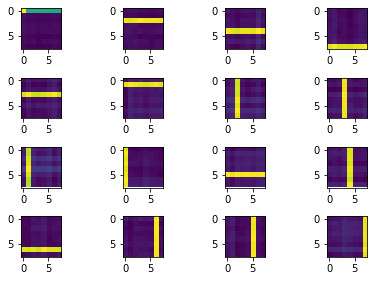

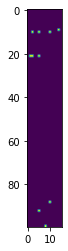

Finished: 5
Finished: 6
Finished: 7
Finished: 8
Finished: 9
Finished: 10
Finished: 11
Finished: 12
Finished: 13
Finished: 14
Finished: 15
Finished: 16
Finished: 17
Finished: 18
Finished: 19
Finished: 20
Finished: 21
Finished: 22
Finished: 23
Finished: 24
Finished: 25
Finished: 26
Finished: 27
Finished: 28
Finished: 29
Finished: 30
Finished: 31
Finished: 32
Finished: 33
Finished: 34
Finished: 35
Finished: 36
Finished: 37
Finished: 38
Finished: 39
Finished: 40
Finished: 41
Finished: 42
Finished: 43
Finished: 44
Finished: 45
Finished: 46
Finished: 47
Finished: 48
Finished: 49
Finished: 50
Finished: 51
Finished: 52
Finished: 53
Finished: 54
Finished: 55
Finished: 56
Finished: 57
Finished: 58
Finished: 59


In [9]:
key_errors = []
mem_errors = []

startnum = 0

for startnum in range(60):

    for j in range(1000):
        i = j + startnum*1000
        inputlayer.setvals(train[i,:])
        network.update()
        #if (j%1000)==999:
            #print(str(i+1)+"/"+str(maxnum))
    
    
    permutation = [0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0]
    outimages = []
    
    for j in range(16):
        lowestmin = 64
        outimage = np.zeros((8,8))
        goestonum = 0
        tnum = 0
        for i in possibletypes:
            mem = np.reshape(network.cgroups[0].getbiases()[:,j],(8,8))
            mem = mem/mem.max()
            er = np.sum(np.abs(mem - i))
            #print(er)
            if (er < lowestmin):
                lowestmin = er
                outimage = np.abs(mem-i)
                goestonum = tnum
            tnum += 1
        outimages.append(outimage)
        permutation[goestonum] = j
    ersum = 0
    for i in outimages:
        ersum += np.sum(i)
    mem_errors.append(ersum/(8*8*16))
    
    
    
    output_keys = np.zeros((100,16))
    rand_keys = np.random.permutation(100)
    
    idx = np.empty_like(permutation)
    idx[permutation] = np.arange(len(permutation))
    
    test_keys = keys[:25000, idx]
    test_this_keys = test_keys[rand_keys,:]
    test_samples_this = test_samples[rand_keys,:]
    for i in range(100):
        inputlayer.setvals(test_samples_this[i,:])
        network.update()
        output_keys[i,:] = foldiaklayer.returnvals()
        #if (i%1000)==999:
            #print(str(i+1)+"/"+str(25000))
    
    key_errors.append(np.sum(np.abs(test_this_keys-output_keys))/np.sum(test_this_keys))
    
    if (startnum==5):
        fig=plt.figure()

        for node_num in range(len(foldiaklayer.nodes)):
            testbias = []
            connects = np.reshape(network.cgroups[0].npconnects, -1)
            for node in inputlayer.nodes:
                for i in connects:
                    if (i.input is node) and (i.output is foldiaklayer.nodes[node_num]):
                        testbias.append(i.bias)
            fig.add_subplot(4,4,node_num+1)

            plt.imshow(np.array(testbias).reshape((8,8)))
        fig.tight_layout()
        #plt.savefig("2020_07_07_bias_figure.png")
        plt.show()

        plt.imshow(np.abs(test_this_keys-output_keys))
        plt.show()
        
    
    print("Finished: " + str(startnum+1))

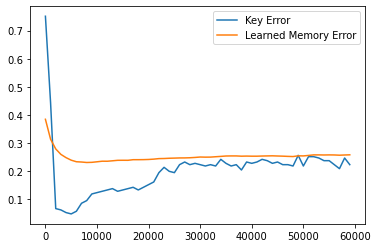

In [10]:
plt.plot([i*1000 for i in range(len(key_errors))], key_errors, label='Key Error')
plt.plot([i*1000 for i in range(len(mem_errors))], mem_errors, label='Learned Memory Error')
plt.legend()
plt.savefig("2020_07_07_LEB_error_graph.png")
plt.show()

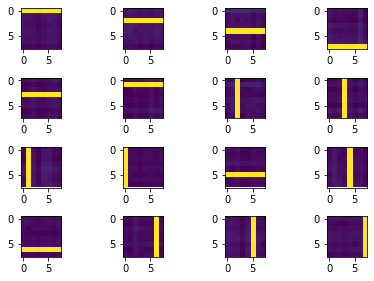

In [11]:
fig=plt.figure()

for node_num in range(len(foldiaklayer.nodes)):
    testbias = []
    connects = np.reshape(network.cgroups[0].npconnects, -1)
    for node in inputlayer.nodes:
        for i in connects:
            if (i.input is node) and (i.output is foldiaklayer.nodes[node_num]):
                testbias.append(i.bias)
    fig.add_subplot(4,4,node_num+1)
            
    plt.imshow(np.array(testbias).reshape((8,8)))
fig.tight_layout()
#plt.savefig("2020_07_07_bias_figure.png")
plt.show()

In [12]:
permutation

[0, 5, 1, 4, 2, 10, 12, 3, 9, 8, 6, 7, 11, 14, 13, 15]

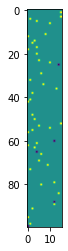

In [14]:
plt.imshow((test_this_keys-output_keys))
plt.show()